# Предобработка аудиоданных

В данном ноутбуке рассмотрим:
- что представляет из себя аудио и как его визуализировать
- что такое resampling
- что такое нормализация
- что такое эквализация
- методы фильтрации
- методы извлечения фич
- что такое windowing
- дополнительные методы предобработки аудио

In [8]:
import os
import numpy as np
import librosa.display
import matplotlib.pyplot as plt

### 1. Визуализация формы волн звукового сигнала

Аудиофайл можно в цифровом виде представляет собой timeseries, который можно визуализировать


Загрузим аудиофайл и отобразим его форму волн

`librosa` - библиотека для загрузки аудио / извлечения фич


Загрузка файла 1-13571-A.ogg %
Размер timeseries  (110272,)
Sampling Rate 22050


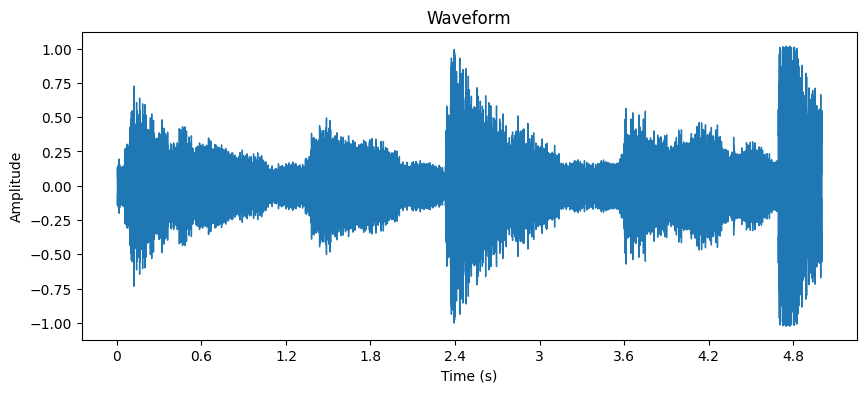

Загрузка файла 2-56926-A.ogg %
Размер timeseries  (110560,)
Sampling Rate 22050


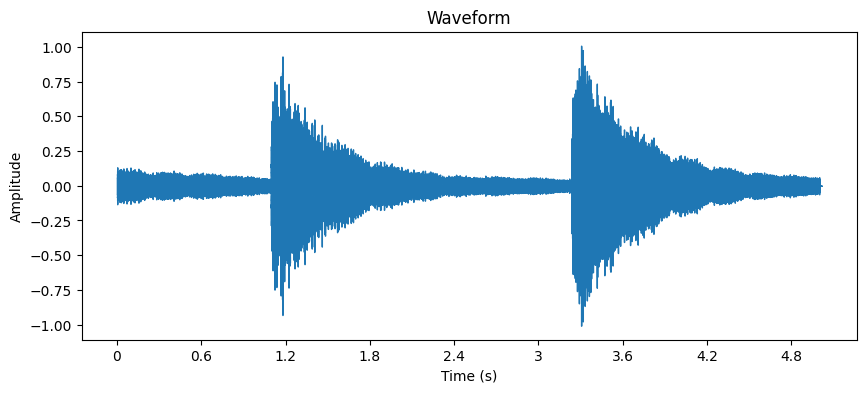

Загрузка файла 3-51376-A.ogg %
Размер timeseries  (110272,)
Sampling Rate 22050


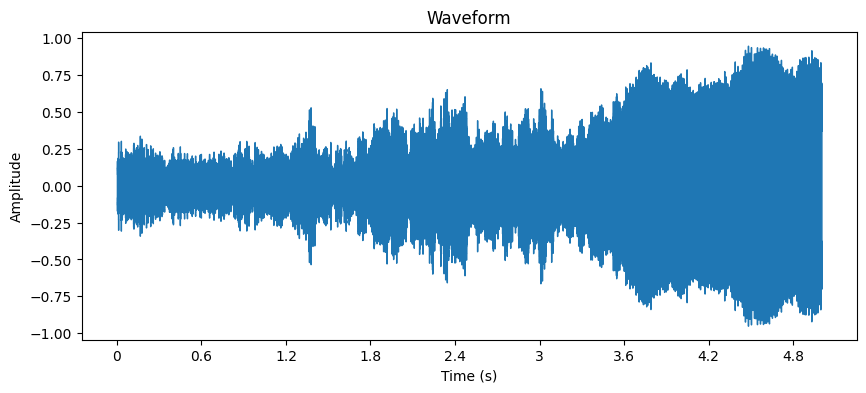

Загрузка файла laugh_1.m4a_1.wav %
Размер timeseries  (110250,)
Sampling Rate 22050


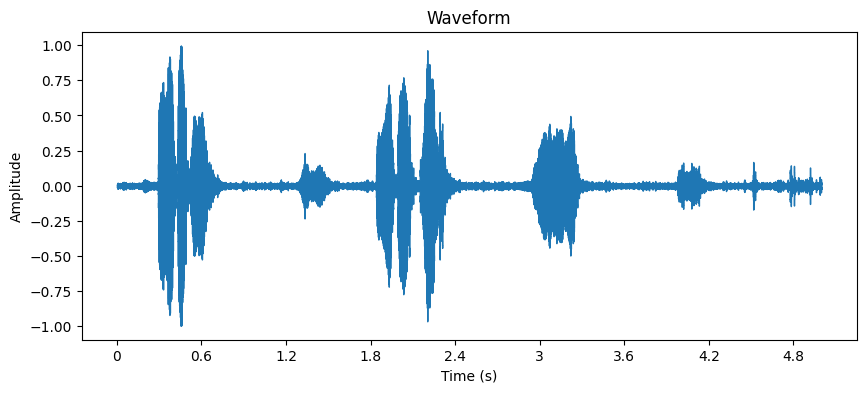

Загрузка файла laugh_1.m4a_2.wav %
Размер timeseries  (110250,)
Sampling Rate 22050


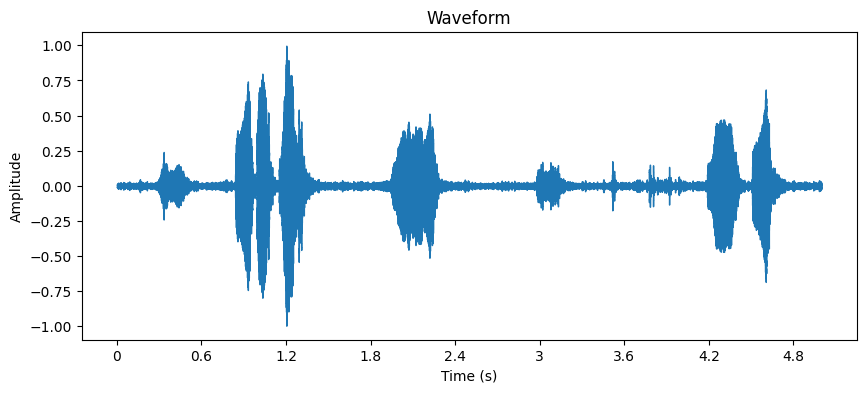

In [2]:
files = os.listdir('data')

for filename in files[:5]:
    
    print(f'Загрузка файла {filename} %')
    audio_ts, sampling_rate = librosa.load(f'data/{filename}')
    print('Размер timeseries ', audio_ts.shape)
    print('Sampling Rate', sampling_rate)

    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio_ts, sr=sampling_rate)
    plt.title('Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

### 2. Resampling

`sr` (`sampling_rate`) - это частота дискретизации; высокая частота дискретизации захватывает широкую полосу частот и высокачастотные детали; низкая частота упрощает размер вычислений, может быть использована для аудио низкого качества

Если `sr=None`, то частота останется как в исходном аудиофайле; Если менять частоту дискретизации, то будет уменьшаться/увеличиваться размер временного ряда для аудио

In [7]:
ts, sr = librosa.load(f'data/{files[10]}', sr=None)
print(ts.shape)

ts, sr = librosa.load(f'data/{files[10]}', sr=10_000)
print(ts.shape)

(8642000,)
(1800417,)


Этот метод (изменение частоты дискретизации и, как следствие, изменение размерности timeseries) называется `resampling` и используется как один из методов предобработки аудио

### 3. Нормализация

Можно провести аналогию с нормализацией простых массивов и выборочных рядов;
* **peak normalization** - масштабирование относительно максимальной амплитуды (не учитывает разность громкости); этот метод может увеличить шум, если в файле динамический диапазон
* rms normalization - масштабирование относительно среднеквадратичной амплитуды (лучше учитевает громкость)
* lufs normalization - масштабирование для более точного учета громкости

Нормализация меняет звук, важно следить за тем, чтобы не превысить амплитуду, которую поддерживает аудиоформат, чтобы избежать искажения

In [9]:
ts

array([-7.8633639e-06,  1.8169501e-05, -2.7854963e-05, ...,
        6.3937935e-03,  1.8172977e-03,  7.6224310e-03], dtype=float32)

In [10]:
peak_ts = ts / np.max(np.abs(ts))

rms_ts = ts * (0.1 / np.sqrt(np.mean(ts**2)))

array([-1.2061633e-05,  2.7870243e-05, -4.2726795e-05, ...,
        9.8074554e-03,  2.7875574e-03,  1.1692066e-02], dtype=float32)

### 4. Вычисление mfcc 

Для выделения спектральных свойств звука используют mfcc; они являются неким упрощением сигнала для последующего анализа/классификации + можно использовать mfcc для оценки "схожести"

Есть встроенная функция извлечения mfcc в библиотеке `librosa`

In [3]:
mfccs = librosa.feature.mfcc(y=audio_ts, sr=sampling_rate, n_mfcc=5)
print(mfccs.shape)

mfccs = librosa.feature.mfcc(y=audio_ts, sr=sampling_rate, n_mfcc=10)
print(mfccs.shape)

(5, 216)
(10, 216)


Параметр `n_mfcc` меняет размерность выходного тензора (и количество мел-кепстральных коэффициентов); это можно использовать для сеток, когда на входе требуется определенное число фич

чем больше `n_mfcc`, тем полезнее для сложных звуков/музыки (больше детализация, что уместно в случае "качественных" аудио); но большое кол-во может привести к избыточности; маленькое кол-во коэффициентов может быть достаточно для классификации/распознавания

In [4]:
mfccs = librosa.feature.mfcc(y=audio_ts, sr=sampling_rate, n_mfcc=100)
print(mfccs.shape)
print(mfccs.T.shape)

(100, 216)
(216, 100)


### 4. Пакет `feature` в библиотеке `librosa`

В librosa есть множество модулей, в том числе `feature`, который дает разнообразные методы извлечения признаков из аудиосигналов; эти признаки используются в задачах классификации и других приложениях

* `mfcc` - самое популярное, извлекает мел-кепстральные коэф. из звука (см. выше); полезно, когда анализируется речь
* `chroma features` - распределение энергии в 12-полутоновой шкале; для музыкального анализа
* `mel spectograma` - спектограмма с мел-шкалированием; для визаулизации и входные данные для ML
* `spectral centroid/bandwidth` - центр тяжести / ширина спектра;
* `zero-crossing rate` - частота пересечения нуля; помогает в анализе насыщенных сигналов и шумов
* `tempogram` - анализ темпа звукового сигнала; для музыки полезно
* `RMS energy` - энергия мощности, анализ громкости
* и другие; есть spectral/rhythm features


In [5]:
zrs = librosa.feature.zero_crossing_rate(audio_ts)
print(zrs.shape)

(1, 216)


(12, 216)


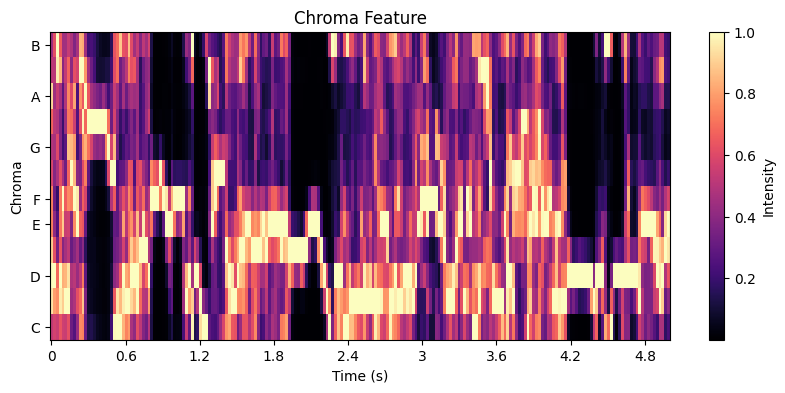

In [6]:
chroma = librosa.feature.chroma_stft(y=audio_ts, sr=sampling_rate)
print(chroma.shape)

plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', sr=sampling_rate)
plt.colorbar(label='Intensity')
plt.title('Chroma Feature')
plt.xlabel('Time (s)')
plt.ylabel('Chroma')
plt.show()


Эти визуализации (например, спектограмма, chroma или визулизации mfcc) позволяют увидеть какие-то выделяющиеся "участки" аудио, которые могут свидетельствовать о наличии шумов или ожидаемых событиях (начало речи и т.д.)

### 5. Фильтрация аудио

* **фильтры нижних и верхних частот** - удаление низкочастотных или высокачастотных сигналов (часто это шумы)
* **echo and reverb reduction** - удаление эха или реверберации
* **полосовые и режекторные фильтры** - фокусирование на определенных частотных диапазонах

Для более настраиваемой (кастомной, самописанной) фильтрации обычно используют `scipy.signal`

In [12]:
import scipy.signal as signal

def custom_filter(ts, cutoff, fs, order=5):
    '''
    Применение фильтра вырезания низких частот из сигнала
    
    Parameters
    ----------
    ts : array
        временной ряд, соответствующий аудио
    cutoff : int
        граничная частота в герцах; частоты ниже это значения будут обрезаны
    fs : int
        частота дискретизации сигнала в Герцах
    order : int
        порядок фильтра Бабичава-Баттерворта (насколько "резкий" будет фильтр)

    '''
    # коэф. для фильтрации
    b, a = signal.butter(order, cutoff / (0.5 * fs), 
                         btype='high', analog=False)
    filtered_ts = signal.filtfilt(b, a, ts)
    return filtered_ts

custom_filter(ts=ts,
              cutoff=1000,
              fs=sr,
              order=10)

array([ 6.44242424e-08,  2.45127084e-05, -2.25802227e-05, ...,
        3.15909340e-03, -3.35462601e-03,  1.95537930e-04])

Для базовой/простой фильтрации используют пакеты `librosa.effects`

* `hpss(y, kernel_size, power, mask)` - разделение `y` на гармоническую и перкуссионную компоненты (полезно для музыки)
* `preemphasis(y, coef)` - усиление высокочастотных компонентов за счет фильтра преэмфаза (для улучшения качества аудио); есть обратная функция
* `trim(y, top_db, ...)` - обрезает тишину с начала и конца
* `pitch_shift(y, sr)` -  изменение высоты звука на заданное кол-во полутонов; меняет тональность

In [14]:
pre_emhasized_ts = librosa.effects.preemphasis(ts)
pre_emhasized_ts

array([-4.1759591e-05,  2.5796964e-05, -4.5479381e-05, ...,
        1.0257088e-02, -4.3846820e-03,  5.8596525e-03], dtype=float32)

In [27]:
ts, rs = librosa.load(f'data/{files[10]}', sr=None)
print(ts.shape)

trimmed_ts, trim_index = librosa.effects.trim(ts)
trim_index

(8642000,)


array([      0, 8642000])

Больше методов фильтрации есть в `pydub`

In [33]:
# from pydub import AudioSegment
# from pydub.effects import low_pass_filter

# audio = AudioSegment.from_file(f'data/{files[1]}')

# print(audio)
# filtered_audio = low_pass_filter(audio,
#                                  cutoff=1000)

# print(filtered_audio)

### 6. Equalization

Регулировка амплитуды на различных частотах для улучшения качества и адаптации к условиям

In [36]:
from scipy.signal import butter, lfilter

def equalization(ts, lowcut, highcut, fs, order=5):
    '''
    Эквализация с помощью scipy
    Parameters
    ----------
    ts : array
        timeseries для аудио
    lowcut : int
        нижняя граница частоты
    highcut : int
        верхняя граница частоты  
    fs : int
        частота дискретизации
    order : int
       порядок фильтра Бабичава-Баттерворта (насколько "резкий" будет фильтр) 
    '''
    coef = fs * 0.5
    low = lowcut / coef
    high = highcut / coef
    b, a = butter(order, [low, high], btype='band')
    filtered_ts = lfilter(b, a, ts)
    return filtered_ts

print(ts)
result = equalization(ts, lowcut=500, highcut=2000, fs=sr, order=10)
print(result)

[-3.4718112e-05  1.5534650e-05  2.6758265e-05 ...  6.8441359e-03
  5.8466988e-04 -3.0566892e-03]
[-1.72248748e-09 -1.83500285e-08 -8.17440631e-08 ...  3.80853533e-03
 -1.76825734e-03 -5.73774049e-03]


### 7. Windowing

Сигнал можно делить на пересекающиеся участки для анализа с использованием оконных функций (например, окно Хэмминга)

In [41]:
window_length = 1024 # длина окна
hop_size = 512 # шаг между окнами

window_function = np.hamming(window_length)
windows = librosa.util.frame(ts, frame_length=window_length, hop_length=hop_size)

print(ts.shape)

windowed_data = windows * windown_function[:, np.newaxis]
windowed_data.shape

(8642000,)


(1024, 16877)

### 8. Дополнительные методы предобработки

- шумподавление 
- обрезка тишины (`librosa.effects.trim`)
- удаление артефактов (`noisereduce`)
- data augmentation (за счет изменения скорости, добавление белого шума и тд)
- есть кастомные наработки по удалению ненужных звуков (github.com/nussl/nussl.git)

In [37]:
import noisereduce as nr

cleaned_ts = nr.reduce_noise(y=ts, sr=sr)
cleaned_ts

/home/ffrankusha/work/university/classifier_of_sound_sources_it_clinic_2024/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


memmap([-5.7827979e-06,  3.2751373e-06, -1.7937319e-07, ...,
         1.1461831e-04,  2.8985279e-04, -4.4760396e-04], dtype=float32)

In [38]:
cleaned_ts = nr.reduce_noise(y=ts, y_noise=ts[5:15], sr=sr)
cleaned_ts

memmap([-5.7827979e-06,  3.2751373e-06, -1.7937319e-07, ...,
         1.1461831e-04,  2.8985279e-04, -4.4760396e-04], dtype=float32)